In [1]:
import tensorflow as tf
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

In [3]:
Init_lr = 1e-4
Batch_size = 32
Channels = 3
Epochs = 10

In [4]:
df = r'data/'
Categories = ['with_mask', 'without_mask']

In [5]:
data = []
label = []

In [6]:
for category in Categories:
    path = os.path.join(df, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        data.append(image)
        label.append(category)
        

F:\Anaconda\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [7]:
# perform one hot encoding
lb = LabelBinarizer()
label = lb.fit_transform(label)
labels = to_categorical(label)

In [8]:
data = np.array(data, dtype='float32')
label = np.array(label)

In [9]:
xtrain, xtest, ytrain, ytest = train_test_split(data, labels, test_size=0.2, stratify=label, random_state=42)


In [10]:
# data augmentation

aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [11]:
# load the mobilenetv2, ensuring the head fully connected layer sets are
# left off
basemodel = MobileNetV2(weights='imagenet', include_top=False, input_tensor=layers.Input(shape=(224, 224, 3)))

In [12]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(7,7))(headmodel)
headmodel = Flatten(name='flatten')(headmodel)
headmodel = Dense(128, activation='relu',)(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(2, activation='softmax')(headmodel)

In [13]:
#place the head FC model on top of the base model (this will become 
# the actual model we will train)
model = Model(inputs = basemodel.input, outputs=headmodel)

In [14]:
# loop over all layers int the base model and freeze them so they will 
# not be updated during the first training process
for layer in basemodel.layers:
    layer.trainable = False

In [15]:
# compile our model

print('info compiling model .....')
opt = Adam(learning_rate=Init_lr, decay=Init_lr / Epochs)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

info compiling model .....


In [16]:
print('Info training Head...')
hist = model.fit(
    aug.flow(xtrain, ytrain, batch_size=Batch_size),
    steps_per_epoch=len(xtrain)//Batch_size,
    validation_steps=len(xtest)//Batch_size,
    epochs=Epochs
)

Info training Head...
Epoch 1/10
188/188 [==============================] - 177s 910ms/step - loss: 0.2749 - accuracy: 0.9050
Epoch 2/10
188/188 [==============================] - 139s 738ms/step - loss: 0.0891 - accuracy: 0.9740
Epoch 3/10
188/188 [==============================] - 133s 703ms/step - loss: 0.0617 - accuracy: 0.9827
Epoch 4/10
188/188 [==============================] - 131s 697ms/step - loss: 0.0517 - accuracy: 0.9855
Epoch 5/10
188/188 [==============================] - 131s 696ms/step - loss: 0.0481 - accuracy: 0.9860
Epoch 6/10
188/188 [==============================] - 118s 624ms/step - loss: 0.0468 - accuracy: 0.9837
Epoch 7/10
188/188 [==============================] - 144s 765ms/step - loss: 0.0431 - accuracy: 0.9864
Epoch 8/10
188/188 [==============================] - 116s 612ms/step - loss: 0.0378 - accuracy: 0.9884
Epoch 9/10
188/188 [==============================] - 110s 582ms/step - loss: 0.0334 - accuracy: 0.9908
Epoch 10/10
188/188 [=====================

In [18]:
# make predictions on the testing set

print('evaluating network...')
predIdxs = model.predict(xtest, batch_size=Batch_size)
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(ytest.argmax(axis=1), predIdxs, target_names=lb.classes_))

evaluating network...
              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.99       745
without_mask       0.99      0.98      0.99       766

    accuracy                           0.99      1511
   macro avg       0.99      0.99      0.99      1511
weighted avg       0.99      0.99      0.99      1511



In [19]:
print('info... saving mask detector model..')
model.save('mask_detector.model', save_format='h5')

info... saving mask detector model..


F:\Anaconda\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


C:\Users\Asus\AppData\Local\Temp/ipykernel_8780/2891508121.py:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(np.arange(0,N), hist.history['loss'], Label='train_loss')


KeyError: 'val_loss'

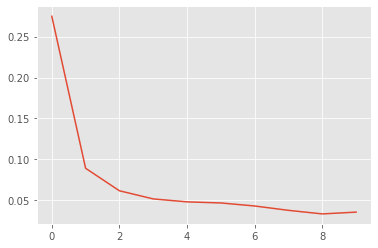

In [20]:
N=Epochsochs
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0,N), hist.history['loss'], Label='train_loss')
plt.plot(np.arange(0,N), hist.history['val_loss'], Label='val_loss')
plt.plot(np.arange(0,N), hist.history['train_acc'], Label='train_acc')
plt.plot(np.arange(0,N), hist.history['val_acc'], Label='val_acc')
plt.title('Training loss and accuracy')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.legend(loc='lower left')
plt.savefig(plot.png)